# Free Energy Principle: Primordial Soup Dynamics

A dynamical simulation of a coupled mechanical-electrochemical system describing a "primordial soup". The time evolution of the system illustrates the __free energy principle (FEP)__ as described in [1].

Full details of the system parameters and several alternative visualizations of the phase space are also found in [1]. 

__References__:

[1] K. Friston, "Life as we know it," _J. of the Royal Society Interface_, vol. 10, no. 20130475, Jun. 2013


# Imports

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import scipy.integrate as integrate

from matplotlib import pyplot as plt

import matplotlib.colors as colors
import matplotlib.cm as cmx
import pickle


# Simulation

## Governing Equations

The general form of the dynamics is: 

$$ \dot{\tilde{\mathbf{p}}} = f_p(\tilde{\mathbf{p}}, \tilde{\mathbf{q}}) + \omega $$
$$ \dot{\tilde{\mathbf{q}}} = f_q(\tilde{\mathbf{p}}, \tilde{\mathbf{q}}) + \omega $$

where $\omega$ is a random fluctuation (e.g. from the heat bath) and $f_{<>}$ are state transition functions. 

For the coupled mechanical-electrochemical system described in [1], the above equations take the following specific forms, describing the electrochemical ($\mathbf{\tilde{q}}$) and mechanical ($\mathbf{\tilde{p}}$) states. The system as a whole is an ensemble of elemental subsystems, each expressing coupled mechanical-electrochemical dynamics. Each subsystem is indexed by $i$, and each subsystem is coupled to the other subsystems in the ensemble.

1. __Electrochemical Dynamics__

$$ \dot{q}^{(i)} = \kappa^{i} \cdot \begin{bmatrix}
10(q^{(i)}_2-q^{(i)}_1) \\
(32+\bar{q}^{(i)}_1)\cdot q^{(i)}_1 - q^{(i)}_2 - x_3 q^{(i)}_1 \\
q^{(i)}_1 q^{(i)}_2 - \frac{8}{3} q^{(i)}_3
\end{bmatrix}  +  \kappa^{i}\cdot \bar{q}^{(i)} + \omega$$

$$ \bar{q}^{(i)} = \sum_{j} q^{(j)} \cdot A_{ij}$$ 

$$ A_{ij} = \left [ |\Delta_{ij}| < 1 \right] $$

$$\Delta_{ij} = p^{(j)} - p^{(i)} $$

where:

- $q^{(i)}$  - the electrochemical state of sub-system $i$.  $q^{(i)}$ is a 3-component vector describing the 3 electrochemical potentials of the 3 chemical species in the subsystem (i.e. $q_1$, $q_2$, and $q_3$).  

- $A_{ij}$ - a coupling matrix which describes the coupling between the electrochemical states of system $i$ and system $j$. If column $j$ of $A_{ij}$ is $\mathbf{0}$, then subsystem $j$ is closed. 

- $\Delta_{ij}$ - a distance matrix, which controls coupling between system $i$ and system $j$ through $A_{ij}$. If $i$ and system $j$ closer than a distance of 1, electrochemical coupling occurs. 

- $\kappa^{i}$ - the reaction rate parameter for subsystem $i$. $\kappa^{i}$ is drawn randomly according to $\kappa^{i} = \frac{1}{32}(1-\text{exp}(-4U))$, where $U \sim U(0,1)$ is a uniform RV on $[0,1]$. 

__NB__: There is a typo in the original paper [1]: $\bar{q}^{(j)}_1$ in the first equation has been changed here to $\bar{q}^{(i)}_1$ to make sense.



2. __Mechanical Dynamics__


$$ \dot{p}^{(i)} = p^{'(i)} + \omega$$ 

$$ p^{'(i)} = \underbrace{\frac{1}{32} \phi^{(i)}}_{\text{inter-system potential}} - \underbrace{\frac{1}{4}p^{'(i)}}_{\text{viscous force}} - \underbrace{\frac{1}{1024}p^{(i)}}_{\text{origin-attracting force}}  + \omega$$



$$ \phi^{(i)}  =  \sum_{j} \frac{\Delta_{ij}}{|\Delta_{ij}|} \cdot \left( \frac{\phi^{(i)}_f}{|\Delta_{ij}|} - \frac{1}{|\Delta_{ij}|^{2}}\right) \cdot A_{ij} $$

$$ \phi^{(i)}_f = 8 \cdot \text{exp}(2\cdot |q^{(j)}_3 - q^{(i)}_3|)-2  $$


where:

- $p^{(i)}$  - the spatial position and momenta of sub-system $i$, expressed as a six component vector $p^{(i)} = (x^{(i)}_1, 
x^{(i)}_2, x^{(i)}_3, x^{'(i)}_1, 
x^{'(i)}_2, x^{'(i)}_3)$

- $\phi^{(i)}_f$ - an attractive electrochemical force. It is defined so that two systems $i$ and $j$ will attract each other strongly if $q^{(j)}_3 = q^{(i)}_3$ . 

- $\phi^{(i)}$ - a repulsive electrochemical force. 


__NB__: In the original paper, it is implied that $\phi^{(i)}$ is a scalar. Instead, like in Coulomb attraction, the $\phi^{(i)}$ should be mutiplied by a differential 3-vector $\mathbf{r}$ from particle $i$ to particle $j$ for each term in $\phi^{(i)}$.





## 1. Simulation Parameters


__Notes on Initial Conditions for Covergence__:

 - Initial __euclidean distances__ between subsystems should be __$>>10^{0}$__ to ensure that initial inter-system forces are not too strong. 
 
 - __Chemical reaction rates__ $\kappa_i$ of the subsystems should be __$\leq 10^{-2}$__ to ensure convergence. 

In [2]:
#define the number of subsystem and the initial conditions of the ensemble
N_systems = 9**2
np.random.seed(0)

#initialize systems in a regular grid centered on the origin with 0 initial momentum
subsystems_per_side = int(np.sqrt(N_systems))
dx = 0.5
dy = 0.5
p = np.array([])
for idx in range(subsystems_per_side):
    for jdx in range(subsystems_per_side):
        x_coord = -(subsystems_per_side-1)*dx/2.0+idx*dx
        y_coord = -(subsystems_per_side-1)*dy/2.0+jdx*dy
        z_coord = 0.0 
        
        p_cur = np.array([x_coord, y_coord, z_coord, 0.0, 0.0, 0.0])
        p = np.hstack((p, p_cur))


#initialize electrochemical potentials to be uniform
q = np.ones(3*N_systems)*(0.01)

states = np.hstack((p,q))

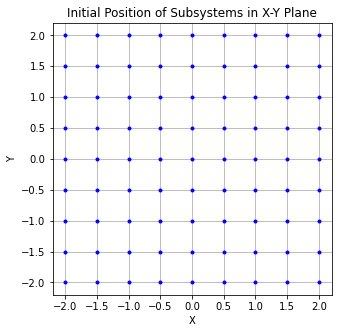

In [3]:
plt.figure(figsize=(5,5))

for idx in range(N_systems):
    plt.plot(states[idx*6],states[idx*6+1],"b.")
plt.grid()
plt.title("Initial Position of Subsystems in X-Y Plane")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [4]:
def dF_dt(t,x, params):
    """
    Arguments
    ---------
    params - dictionary
            params["N_subsytems"] - number of subsystems in ensemble 
            params["kappas"] - array of reaction rate parameters
            
    x - ndarray 
        
        State vector. Arranged as an Mx1 matrix, where:
                    
                      M = (dimensionality of position and momenta)*
                          (number of systems in ensemble ) + 
                          (dimensionality of electrochemical state) *
                          (number of systems in ensemble )
                      
                      That is, the state vector is a vector where the first 6*N components 
                      correspond to the position and momenta state vectors of the N subsystems 
                      concatenated together and the last 3*N components correspond 
                      to the electrochemical state vectors 
                      of the N subsystems concatenated together.
                    
        
    t - float 
        
        Time
        
    Returns
    --------
    
    dx - nd.array
    
        The state vector differential
    
    """
    print("t: %.3f"%t)
    
    N_subsystems = params["N_subsystems"]
    
    # calculate delta matrix
    delta = np.zeros((N_subsystems, N_subsystems))
   
    ## lazy O(n^2) calculation
    for idx in range(params["N_subsystems"] ):
        for jdx in range(params["N_subsystems"]):
            
            #avoid self-interaction in delta 
            if idx == jdx:
                delta[idx][jdx]  = 1.0
                continue
            
            #only calculate for other subsystems
            delta[idx][jdx] = np.linalg.norm(x[(6*idx):(6*idx+3)] - x[(6*jdx):(6*jdx+3)])
            
    
    #calculate A matrix 
    A = np.zeros(delta.shape)
    mask = np.abs(delta) < 1.0
    A[mask] = np.ones(delta.shape)[mask]
    
    
    # initialize differential vector
    dx = np.zeros(x.shape)
    
    ################################### electrochemical dynamics
    ec_starting_idx = 6*N_subsystems 
    
    for idx in range(N_subsystems):
        base_idx = ec_starting_idx + idx*3
        
        #kappa
        kappa_i = params["kappas"][idx]
        
        #calculate q_bar for system idx
        vectors_2_sum = [A[idx][_]*x[(ec_starting_idx+3*_):(ec_starting_idx+3*_+3)] \
                         for _ in range(N_subsystems)]
        
        q_bar = np.sum( vectors_2_sum, axis=0)
        
        #current q state
        q = x[base_idx:base_idx+3]
        
        
        #update the electrochemical state
        omega = params["fluctuation_amplitude"]*np.random.normal(loc=0, scale=params["fluctuation_std"])
        
        dx[base_idx:base_idx+3] = kappa_i*np.array([10*(q[1]-q[0]), \
                                                 (32+q_bar[0])*q[0]-q[1]-x[6*idx+2]*q[0],  
                                                 q[0]*q[1]-(8.0/3.0)*q[2]]) + \
                                                kappa_i*q_bar + omega
        
        #print("dq",dx[base_idx:base_idx+3])
        
    ################################### mechanical dynamics

    #### calculate phi_fs
    phi_fs = np.zeros((N_subsystems,N_subsystems))
    
    ec_starting_idx = 6*N_subsystems 
    
    ### calculate phi_fs as a lower triangular matrix
    for idx in range(N_subsystems):
        for jdx in range(idx):
            phi_fs[idx][jdx] = 8*np.exp(2*np.abs(x[ec_starting_idx+idx*3+2]-x[ec_starting_idx+jdx*3+2]))-2
            
            
    ## mechanical dynamics proper
    for idx in range(N_subsystems):
        base_idx = idx*6
        
        #calculate phi_i, which is the coupling to the electrochemical dynamics
        ## NOTE: the dependence on delta (which is highly nonlinear due to its indicator function-like 
        # behavior) and phi_f (which is exponential) causes the PDE solver to diverge easily. 
        # Care must be taken to either carefully choose initial conditions,
        # tune the parameters, or modify these dependencies to ensure convergence. 
        # phi_i should be on the order of 10^1 to 10^3. 
        
        phi_i = np.zeros(3)
        for jdx in range(N_subsystems):
            
            #avoid self-potential
            if idx==jdx:
                continue
            
            #account for lower-triangular phi_f matrix
            if idx > jdx:
                phi_f = phi_fs[idx][jdx]
            else:
                phi_f = phi_fs[jdx][idx]
                
            delta_ij = delta[idx][jdx]
                
            phi_i+=((delta_ij)/np.abs(delta_ij))*((phi_f/delta_ij)-1.0/(delta_ij**2))*A[idx][jdx]* \
                        (x[jdx*6:jdx*6+3]-x[base_idx:base_idx+3])
            
        
        #print("phi_i:", phi_i)
        
        #momenta differential
        omega = params["fluctuation_amplitude"]*np.random.normal(loc=0, scale=params["fluctuation_std"])
                                                                                     
        dx[base_idx+3:base_idx+6] = phi_i -0.25*x[base_idx+3:base_idx+6] - \
                                    (1.0/1024)*x[base_idx:base_idx+3] + omega
        
        
        
        #position differential
        omega = params["fluctuation_amplitude"]*np.random.normal(loc=0, scale=params["fluctuation_std"])
                                                                                     
        dx[base_idx:base_idx+3]  = x[base_idx+3:base_idx+6]+omega
        
        
        
                 
    return dx



In [5]:
params = {"N_subsystems": N_systems, "kappas":np.ones(N_systems)*0.01, \
          "fluctuation_std":1.0, "fluctuation_amplitude":0.1}



In [6]:
## debugging code 
#dx = dF_dt(0.0,states, params)
#print(dx)

## 2. PDE Solution

In [7]:
solution = solve_ivp(dF_dt, [0,10.0], states, dense_output = True, args=(params,))
print("Solution status: %s"%("success" if solution.status==0 else "premature termination!"))

t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t: 0.000
t

t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.006
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.007
t: 0.008
t: 0.008
t: 0.008
t: 0.008
t: 0.008
t: 0.008
t: 0.008
t: 0.008
t: 0.008
t: 0.008
t: 0.008
t: 0.008
t: 0.008
t: 0.008
t: 0.008
t

t: 0.026
t: 0.026
t: 0.026
t: 0.026
t: 0.026
t: 0.026
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.027
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.028
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t: 0.029
t

t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.054
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.055
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.056
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t: 0.057
t

t: 0.084
t: 0.084
t: 0.084
t: 0.084
t: 0.084
t: 0.084
t: 0.084
t: 0.084
t: 0.084
t: 0.084
t: 0.084
t: 0.084
t: 0.084
t: 0.084
t: 0.084
t: 0.084
t: 0.084
t: 0.084
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.085
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.086
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.087
t: 0.088
t: 0.088
t: 0.088
t: 0.088
t: 0.088
t

t: 0.115
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.116
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.117
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.118
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.119
t: 0.120
t: 0.120
t

t: 0.151
t: 0.151
t: 0.151
t: 0.151
t: 0.151
t: 0.151
t: 0.151
t: 0.151
t: 0.151
t: 0.151
t: 0.151
t: 0.151
t: 0.151
t: 0.151
t: 0.151
t: 0.151
t: 0.151
t: 0.151
t: 0.151
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.152
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.153
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.154
t: 0.155
t: 0.155
t: 0.155
t: 0.155
t: 0.155
t: 0.155
t: 0.155
t: 0.155
t: 0.155
t: 0.155
t: 0.155
t: 0.155
t: 0.155
t: 0.155
t

t: 0.187
t: 0.187
t: 0.187
t: 0.187
t: 0.187
t: 0.187
t: 0.187
t: 0.187
t: 0.187
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.188
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.189
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.190
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t: 0.191
t

t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.225
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.226
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.227
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.228
t: 0.229
t: 0.229
t: 0.229
t: 0.229
t: 0.229
t: 0.229
t: 0.229
t: 0.229
t: 0.229
t: 0.229
t: 0.229
t: 0.229
t: 0.229
t: 0.229
t: 0.229
t: 0.229
t: 0.229
t

t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.263
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.264
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.265
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.266
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t: 0.267
t

t: 0.304
t: 0.304
t: 0.304
t: 0.304
t: 0.304
t: 0.304
t: 0.304
t: 0.304
t: 0.304
t: 0.304
t: 0.304
t: 0.304
t: 0.304
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.305
t: 0.306
t: 0.306
t: 0.306
t: 0.306
t: 0.306
t: 0.306
t: 0.306
t: 0.306
t: 0.306
t: 0.306
t: 0.306
t: 0.306
t: 0.306
t: 0.306
t: 0.306
t: 0.306
t: 0.306
t: 0.306
t: 0.306
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.307
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.308
t: 0.309
t: 0.309
t: 0.309
t: 0.309
t: 0.309
t: 0.309
t: 0.309
t: 0.309
t: 0.309
t: 0.309
t: 0.309
t: 0.309
t: 0.309
t: 0.309
t: 0.309
t: 0.309
t

t: 0.354
t: 0.354
t: 0.354
t: 0.354
t: 0.354
t: 0.354
t: 0.354
t: 0.355
t: 0.355
t: 0.355
t: 0.355
t: 0.355
t: 0.355
t: 0.355
t: 0.355
t: 0.355
t: 0.355
t: 0.355
t: 0.355
t: 0.355
t: 0.355
t: 0.355
t: 0.355
t: 0.356
t: 0.356
t: 0.356
t: 0.356
t: 0.356
t: 0.356
t: 0.356
t: 0.356
t: 0.356
t: 0.356
t: 0.356
t: 0.356
t: 0.356
t: 0.356
t: 0.356
t: 0.356
t: 0.356
t: 0.357
t: 0.357
t: 0.357
t: 0.357
t: 0.357
t: 0.357
t: 0.357
t: 0.357
t: 0.357
t: 0.357
t: 0.357
t: 0.357
t: 0.357
t: 0.357
t: 0.358
t: 0.358
t: 0.358
t: 0.358
t: 0.358
t: 0.358
t: 0.358
t: 0.358
t: 0.358
t: 0.358
t: 0.358
t: 0.358
t: 0.358
t: 0.358
t: 0.358
t: 0.358
t: 0.358
t: 0.359
t: 0.359
t: 0.359
t: 0.359
t: 0.359
t: 0.359
t: 0.359
t: 0.359
t: 0.359
t: 0.359
t: 0.359
t: 0.359
t: 0.359
t: 0.359
t: 0.359
t: 0.359
t: 0.359
t: 0.360
t: 0.360
t: 0.360
t: 0.360
t: 0.360
t: 0.360
t: 0.360
t: 0.360
t: 0.360
t: 0.360
t: 0.360
t: 0.360
t: 0.360
t: 0.360
t: 0.360
t: 0.360
t: 0.360
t: 0.361
t: 0.361
t: 0.361
t: 0.361
t: 0.361
t: 0.361
t

t: 0.417
t: 0.417
t: 0.417
t: 0.417
t: 0.417
t: 0.417
t: 0.417
t: 0.417
t: 0.417
t: 0.417
t: 0.418
t: 0.418
t: 0.418
t: 0.418
t: 0.418
t: 0.418
t: 0.418
t: 0.418
t: 0.418
t: 0.418
t: 0.418
t: 0.418
t: 0.418
t: 0.418
t: 0.419
t: 0.419
t: 0.419
t: 0.419
t: 0.419
t: 0.419
t: 0.419
t: 0.419
t: 0.419
t: 0.419
t: 0.419
t: 0.419
t: 0.420
t: 0.420
t: 0.420
t: 0.420
t: 0.420
t: 0.420
t: 0.420
t: 0.420
t: 0.420
t: 0.420
t: 0.420
t: 0.420
t: 0.420
t: 0.420
t: 0.421
t: 0.421
t: 0.421
t: 0.421
t: 0.421
t: 0.421
t: 0.421
t: 0.421
t: 0.421
t: 0.421
t: 0.421
t: 0.421
t: 0.421
t: 0.421
t: 0.422
t: 0.422
t: 0.422
t: 0.422
t: 0.422
t: 0.422
t: 0.422
t: 0.422
t: 0.422
t: 0.422
t: 0.422
t: 0.422
t: 0.422
t: 0.422
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.422
t: 0.422
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.422
t: 0.422
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t: 0.423
t

t: 0.509
t: 0.509
t: 0.509
t: 0.509
t: 0.509
t: 0.509
t: 0.510
t: 0.510
t: 0.510
t: 0.510
t: 0.510
t: 0.510
t: 0.510
t: 0.511
t: 0.511
t: 0.511
t: 0.511
t: 0.511
t: 0.511
t: 0.512
t: 0.512
t: 0.512
t: 0.512
t: 0.512
t: 0.512
t: 0.513
t: 0.513
t: 0.513
t: 0.513
t: 0.513
t: 0.513
t: 0.513
t: 0.513
t: 0.513
t: 0.513
t: 0.514
t: 0.514
t: 0.514
t: 0.514
t: 0.514
t: 0.514
t: 0.514
t: 0.515
t: 0.515
t: 0.515
t: 0.515
t: 0.515
t: 0.515
t: 0.515
t: 0.516
t: 0.516
t: 0.516
t: 0.516
t: 0.516
t: 0.516
t: 0.517
t: 0.517
t: 0.517
t: 0.517
t: 0.517
t: 0.517
t: 0.517
t: 0.518
t: 0.518
t: 0.518
t: 0.518
t: 0.518
t: 0.518
t: 0.518
t: 0.519
t: 0.519
t: 0.519
t: 0.519
t: 0.519
t: 0.519
t: 0.519
t: 0.519
t: 0.520
t: 0.520
t: 0.520
t: 0.520
t: 0.520
t: 0.520
t: 0.520
t: 0.521
t: 0.521
t: 0.521
t: 0.521
t: 0.521
t: 0.521
t: 0.521
t: 0.522
t: 0.522
t: 0.522
t: 0.522
t: 0.522
t: 0.522
t: 0.523
t: 0.523
t: 0.523
t: 0.523
t: 0.523
t: 0.523
t: 0.524
t: 0.524
t: 0.524
t: 0.524
t: 0.524
t: 0.524
t: 0.524
t: 0.524
t

t: 0.638
t: 0.638
t: 0.638
t: 0.639
t: 0.639
t: 0.639
t: 0.639
t: 0.639
t: 0.639
t: 0.639
t: 0.640
t: 0.640
t: 0.640
t: 0.640
t: 0.640
t: 0.640
t: 0.641
t: 0.641
t: 0.641
t: 0.641
t: 0.641
t: 0.641
t: 0.641
t: 0.641
t: 0.642
t: 0.642
t: 0.642
t: 0.642
t: 0.642
t: 0.642
t: 0.643
t: 0.643
t: 0.643
t: 0.643
t: 0.643
t: 0.643
t: 0.644
t: 0.644
t: 0.644
t: 0.644
t: 0.644
t: 0.644
t: 0.644
t: 0.644
t: 0.645
t: 0.645
t: 0.645
t: 0.645
t: 0.645
t: 0.645
t: 0.646
t: 0.646
t: 0.646
t: 0.646
t: 0.646
t: 0.646
t: 0.647
t: 0.647
t: 0.647
t: 0.647
t: 0.647
t: 0.647
t: 0.648
t: 0.648
t: 0.648
t: 0.648
t: 0.648
t: 0.648
t: 0.649
t: 0.649
t: 0.649
t: 0.649
t: 0.649
t: 0.649
t: 0.649
t: 0.650
t: 0.650
t: 0.650
t: 0.650
t: 0.650
t: 0.650
t: 0.651
t: 0.651
t: 0.651
t: 0.651
t: 0.651
t: 0.651
t: 0.651
t: 0.652
t: 0.652
t: 0.652
t: 0.652
t: 0.652
t: 0.652
t: 0.653
t: 0.653
t: 0.653
t: 0.653
t: 0.653
t: 0.653
t: 0.654
t: 0.654
t: 0.654
t: 0.654
t: 0.654
t: 0.654
t: 0.655
t: 0.655
t: 0.655
t: 0.655
t: 0.655
t

t: 0.797
t: 0.797
t: 0.797
t: 0.798
t: 0.798
t: 0.798
t: 0.798
t: 0.798
t: 0.798
t: 0.799
t: 0.799
t: 0.799
t: 0.799
t: 0.799
t: 0.799
t: 0.800
t: 0.800
t: 0.800
t: 0.800
t: 0.800
t: 0.800
t: 0.801
t: 0.801
t: 0.801
t: 0.801
t: 0.801
t: 0.801
t: 0.802
t: 0.802
t: 0.802
t: 0.802
t: 0.802
t: 0.802
t: 0.803
t: 0.803
t: 0.803
t: 0.803
t: 0.803
t: 0.803
t: 0.803
t: 0.804
t: 0.804
t: 0.804
t: 0.804
t: 0.804
t: 0.805
t: 0.805
t: 0.805
t: 0.805
t: 0.805
t: 0.805
t: 0.806
t: 0.806
t: 0.806
t: 0.806
t: 0.806
t: 0.806
t: 0.807
t: 0.807
t: 0.807
t: 0.807
t: 0.807
t: 0.807
t: 0.808
t: 0.808
t: 0.808
t: 0.808
t: 0.808
t: 0.808
t: 0.809
t: 0.809
t: 0.809
t: 0.809
t: 0.809
t: 0.809
t: 0.810
t: 0.810
t: 0.810
t: 0.810
t: 0.810
t: 0.810
t: 0.811
t: 0.811
t: 0.811
t: 0.811
t: 0.811
t: 0.812
t: 0.812
t: 0.812
t: 0.812
t: 0.812
t: 0.812
t: 0.813
t: 0.813
t: 0.813
t: 0.813
t: 0.813
t: 0.813
t: 0.814
t: 0.814
t: 0.814
t: 0.814
t: 0.814
t: 0.815
t: 0.815
t: 0.815
t: 0.815
t: 0.815
t: 0.815
t: 0.816
t: 0.816
t

t: 0.968
t: 0.968
t: 0.968
t: 0.969
t: 0.969
t: 0.969
t: 0.969
t: 0.969
t: 0.969
t: 0.970
t: 0.970
t: 0.970
t: 0.970
t: 0.971
t: 0.971
t: 0.971
t: 0.972
t: 0.972
t: 0.972
t: 0.972
t: 0.972
t: 0.973
t: 0.973
t: 0.973
t: 0.973
t: 0.973
t: 0.973
t: 0.974
t: 0.974
t: 0.974
t: 0.974
t: 0.974
t: 0.975
t: 0.975
t: 0.975
t: 0.975
t: 0.975
t: 0.976
t: 0.976
t: 0.976
t: 0.977
t: 0.977
t: 0.977
t: 0.977
t: 0.977
t: 0.978
t: 0.978
t: 0.978
t: 0.978
t: 0.978
t: 0.978
t: 0.979
t: 0.979
t: 0.979
t: 0.979
t: 0.979
t: 0.979
t: 0.980
t: 0.980
t: 0.980
t: 0.980
t: 0.980
t: 0.980
t: 0.981
t: 0.981
t: 0.981
t: 0.981
t: 0.982
t: 0.982
t: 0.982
t: 0.982
t: 0.982
t: 0.982
t: 0.983
t: 0.983
t: 0.983
t: 0.984
t: 0.984
t: 0.984
t: 0.984
t: 0.984
t: 0.985
t: 0.985
t: 0.985
t: 0.985
t: 0.985
t: 0.985
t: 0.986
t: 0.986
t: 0.986
t: 0.986
t: 0.987
t: 0.987
t: 0.987
t: 0.987
t: 0.988
t: 0.988
t: 0.988
t: 0.988
t: 0.989
t: 0.989
t: 0.989
t: 0.989
t: 0.989
t: 0.989
t: 0.990
t: 0.990
t: 0.990
t: 0.990
t: 0.991
t: 0.991
t

t: 1.162
t: 1.162
t: 1.163
t: 1.163
t: 1.163
t: 1.163
t: 1.164
t: 1.164
t: 1.164
t: 1.164
t: 1.165
t: 1.165
t: 1.165
t: 1.165
t: 1.165
t: 1.165
t: 1.166
t: 1.166
t: 1.166
t: 1.166
t: 1.166
t: 1.167
t: 1.167
t: 1.167
t: 1.168
t: 1.168
t: 1.168
t: 1.168
t: 1.169
t: 1.169
t: 1.169
t: 1.169
t: 1.169
t: 1.169
t: 1.170
t: 1.170
t: 1.170
t: 1.170
t: 1.171
t: 1.171
t: 1.171
t: 1.171
t: 1.172
t: 1.172
t: 1.172
t: 1.172
t: 1.173
t: 1.173
t: 1.173
t: 1.173
t: 1.173
t: 1.173
t: 1.174
t: 1.174
t: 1.174
t: 1.174
t: 1.175
t: 1.175
t: 1.175
t: 1.176
t: 1.176
t: 1.176
t: 1.176
t: 1.176
t: 1.177
t: 1.177
t: 1.177
t: 1.177
t: 1.177
t: 1.178
t: 1.178
t: 1.178
t: 1.179
t: 1.179
t: 1.179
t: 1.179
t: 1.180
t: 1.180
t: 1.180
t: 1.180
t: 1.180
t: 1.180
t: 1.181
t: 1.181
t: 1.181
t: 1.181
t: 1.182
t: 1.182
t: 1.182
t: 1.183
t: 1.183
t: 1.183
t: 1.183
t: 1.183
t: 1.184
t: 1.184
t: 1.184
t: 1.184
t: 1.184
t: 1.185
t: 1.185
t: 1.185
t: 1.186
t: 1.186
t: 1.186
t: 1.186
t: 1.187
t: 1.187
t: 1.187
t: 1.187
t: 1.187
t

t: 1.384
t: 1.384
t: 1.384
t: 1.384
t: 1.385
t: 1.385
t: 1.385
t: 1.386
t: 1.386
t: 1.386
t: 1.386
t: 1.387
t: 1.387
t: 1.387
t: 1.387
t: 1.388
t: 1.388
t: 1.389
t: 1.389
t: 1.389
t: 1.389
t: 1.389
t: 1.389
t: 1.390
t: 1.390
t: 1.390
t: 1.390
t: 1.391
t: 1.391
t: 1.392
t: 1.392
t: 1.392
t: 1.392
t: 1.392
t: 1.393
t: 1.393
t: 1.394
t: 1.394
t: 1.394
t: 1.394
t: 1.394
t: 1.395
t: 1.395
t: 1.395
t: 1.395
t: 1.396
t: 1.396
t: 1.397
t: 1.397
t: 1.397
t: 1.397
t: 1.397
t: 1.398
t: 1.398
t: 1.399
t: 1.399
t: 1.399
t: 1.399
t: 1.399
t: 1.400
t: 1.400
t: 1.400
t: 1.400
t: 1.401
t: 1.401
t: 1.402
t: 1.402
t: 1.402
t: 1.402
t: 1.402
t: 1.402
t: 1.403
t: 1.403
t: 1.403
t: 1.403
t: 1.404
t: 1.404
t: 1.405
t: 1.405
t: 1.405
t: 1.405
t: 1.405
t: 1.406
t: 1.406
t: 1.406
t: 1.407
t: 1.407
t: 1.407
t: 1.407
t: 1.408
t: 1.408
t: 1.408
t: 1.408
t: 1.408
t: 1.409
t: 1.409
t: 1.409
t: 1.410
t: 1.410
t: 1.410
t: 1.410
t: 1.411
t: 1.411
t: 1.411
t: 1.411
t: 1.411
t: 1.412
t: 1.412
t: 1.412
t: 1.413
t: 1.413
t

t: 1.623
t: 1.623
t: 1.623
t: 1.623
t: 1.623
t: 1.624
t: 1.624
t: 1.624
t: 1.624
t: 1.625
t: 1.625
t: 1.626
t: 1.626
t: 1.626
t: 1.626
t: 1.626
t: 1.626
t: 1.627
t: 1.627
t: 1.627
t: 1.627
t: 1.628
t: 1.628
t: 1.629
t: 1.629
t: 1.629
t: 1.629
t: 1.629
t: 1.630
t: 1.630
t: 1.630
t: 1.631
t: 1.631
t: 1.631
t: 1.631
t: 1.632
t: 1.632
t: 1.632
t: 1.632
t: 1.633
t: 1.633
t: 1.634
t: 1.634
t: 1.634
t: 1.634
t: 1.634
t: 1.635
t: 1.635
t: 1.636
t: 1.636
t: 1.636
t: 1.636
t: 1.636
t: 1.637
t: 1.637
t: 1.638
t: 1.638
t: 1.638
t: 1.638
t: 1.639
t: 1.639
t: 1.639
t: 1.639
t: 1.640
t: 1.640
t: 1.641
t: 1.641
t: 1.641
t: 1.641
t: 1.642
t: 1.642
t: 1.643
t: 1.643
t: 1.643
t: 1.643
t: 1.643
t: 1.644
t: 1.645
t: 1.645
t: 1.645
t: 1.645
t: 1.645
t: 1.645
t: 1.646
t: 1.647
t: 1.647
t: 1.647
t: 1.647
t: 1.647
t: 1.648
t: 1.649
t: 1.649
t: 1.649
t: 1.649
t: 1.649
t: 1.650
t: 1.651
t: 1.651
t: 1.651
t: 1.651
t: 1.651
t: 1.652
t: 1.652
t: 1.653
t: 1.653
t: 1.653
t: 1.653
t: 1.654
t: 1.654
t: 1.655
t: 1.655
t

t: 1.897
t: 1.897
t: 1.897
t: 1.898
t: 1.898
t: 1.899
t: 1.899
t: 1.899
t: 1.899
t: 1.899
t: 1.899
t: 1.900
t: 1.900
t: 1.901
t: 1.901
t: 1.901
t: 1.901
t: 1.902
t: 1.902
t: 1.902
t: 1.902
t: 1.902
t: 1.903
t: 1.903
t: 1.903
t: 1.904
t: 1.904
t: 1.904
t: 1.904
t: 1.905
t: 1.905
t: 1.905
t: 1.905
t: 1.906
t: 1.906
t: 1.907
t: 1.907
t: 1.907
t: 1.907
t: 1.907
t: 1.907
t: 1.908
t: 1.908
t: 1.909
t: 1.909
t: 1.909
t: 1.909
t: 1.910
t: 1.910
t: 1.910
t: 1.910
t: 1.911
t: 1.911
t: 1.912
t: 1.912
t: 1.912
t: 1.912
t: 1.912
t: 1.913
t: 1.913
t: 1.914
t: 1.914
t: 1.914
t: 1.914
t: 1.914
t: 1.915
t: 1.915
t: 1.915
t: 1.915
t: 1.916
t: 1.916
t: 1.917
t: 1.917
t: 1.917
t: 1.917
t: 1.918
t: 1.918
t: 1.919
t: 1.919
t: 1.919
t: 1.919
t: 1.919
t: 1.920
t: 1.921
t: 1.921
t: 1.921
t: 1.921
t: 1.921
t: 1.921
t: 1.922
t: 1.923
t: 1.923
t: 1.923
t: 1.923
t: 1.923
t: 1.924
t: 1.924
t: 1.925
t: 1.925
t: 1.925
t: 1.925
t: 1.926
t: 1.926
t: 1.926
t: 1.926
t: 1.927
t: 1.927
t: 1.928
t: 1.928
t: 1.928
t: 1.928
t

t: 2.141
t: 2.141
t: 2.141
t: 2.142
t: 2.142
t: 2.143
t: 2.143
t: 2.143
t: 2.143
t: 2.143
t: 2.143
t: 2.144
t: 2.144
t: 2.144
t: 2.144
t: 2.145
t: 2.145
t: 2.145
t: 2.146
t: 2.146
t: 2.146
t: 2.146
t: 2.146
t: 2.147
t: 2.147
t: 2.147
t: 2.147
t: 2.147
t: 2.147
t: 2.148
t: 2.148
t: 2.148
t: 2.148
t: 2.149
t: 2.149
t: 2.149
t: 2.149
t: 2.150
t: 2.150
t: 2.150
t: 2.150
t: 2.151
t: 2.151
t: 2.151
t: 2.151
t: 2.151
t: 2.151
t: 2.152
t: 2.152
t: 2.152
t: 2.152
t: 2.153
t: 2.153
t: 2.153
t: 2.153
t: 2.154
t: 2.154
t: 2.154
t: 2.154
t: 2.155
t: 2.155
t: 2.155
t: 2.155
t: 2.155
t: 2.156
t: 2.156
t: 2.156
t: 2.157
t: 2.157
t: 2.157
t: 2.157
t: 2.158
t: 2.158
t: 2.158
t: 2.158
t: 2.158
t: 2.158
t: 2.159
t: 2.159
t: 2.160
t: 2.160
t: 2.160
t: 2.160
t: 2.161
t: 2.161
t: 2.161
t: 2.161
t: 2.162
t: 2.162
t: 2.163
t: 2.163
t: 2.163
t: 2.163
t: 2.163
t: 2.164
t: 2.164
t: 2.165
t: 2.165
t: 2.165
t: 2.165
t: 2.165
t: 2.166
t: 2.166
t: 2.166
t: 2.166
t: 2.167
t: 2.167
t: 2.168
t: 2.168
t: 2.168
t: 2.168
t

t: 2.394
t: 2.394
t: 2.394
t: 2.394
t: 2.394
t: 2.395
t: 2.396
t: 2.396
t: 2.396
t: 2.396
t: 2.396
t: 2.397
t: 2.397
t: 2.398
t: 2.398
t: 2.398
t: 2.398
t: 2.399
t: 2.399
t: 2.399
t: 2.399
t: 2.400
t: 2.400
t: 2.401
t: 2.401
t: 2.401
t: 2.401
t: 2.402
t: 2.402
t: 2.403
t: 2.403
t: 2.403
t: 2.403
t: 2.403
t: 2.404
t: 2.404
t: 2.405
t: 2.405
t: 2.405
t: 2.405
t: 2.405
t: 2.406
t: 2.406
t: 2.407
t: 2.407
t: 2.407
t: 2.407
t: 2.408
t: 2.408
t: 2.409
t: 2.409
t: 2.409
t: 2.409
t: 2.410
t: 2.410
t: 2.411
t: 2.411
t: 2.411
t: 2.411
t: 2.412
t: 2.412
t: 2.413
t: 2.413
t: 2.413
t: 2.413
t: 2.414
t: 2.414
t: 2.415
t: 2.415
t: 2.415
t: 2.415
t: 2.416
t: 2.417
t: 2.417
t: 2.417
t: 2.417
t: 2.417
t: 2.418
t: 2.419
t: 2.419
t: 2.419
t: 2.419
t: 2.419
t: 2.420
t: 2.421
t: 2.421
t: 2.421
t: 2.421
t: 2.422
t: 2.423
t: 2.423
t: 2.423
t: 2.423
t: 2.423
t: 2.424
t: 2.425
t: 2.425
t: 2.425
t: 2.425
t: 2.425
t: 2.426
t: 2.427
t: 2.427
t: 2.427
t: 2.427
t: 2.428
t: 2.428
t: 2.429
t: 2.429
t: 2.429
t: 2.429
t

t: 2.675
t: 2.675
t: 2.675
t: 2.675
t: 2.676
t: 2.676
t: 2.677
t: 2.677
t: 2.677
t: 2.677
t: 2.677
t: 2.677
t: 2.678
t: 2.678
t: 2.679
t: 2.679
t: 2.679
t: 2.679
t: 2.680
t: 2.680
t: 2.680
t: 2.680
t: 2.681
t: 2.681
t: 2.682
t: 2.682
t: 2.682
t: 2.682
t: 2.682
t: 2.683
t: 2.683
t: 2.684
t: 2.684
t: 2.684
t: 2.684
t: 2.684
t: 2.685
t: 2.685
t: 2.685
t: 2.685
t: 2.686
t: 2.686
t: 2.687
t: 2.687
t: 2.687
t: 2.687
t: 2.687
t: 2.688
t: 2.689
t: 2.689
t: 2.689
t: 2.689
t: 2.689
t: 2.689
t: 2.690
t: 2.690
t: 2.691
t: 2.691
t: 2.691
t: 2.691
t: 2.692
t: 2.692
t: 2.692
t: 2.692
t: 2.693
t: 2.693
t: 2.694
t: 2.694
t: 2.694
t: 2.694
t: 2.694
t: 2.694
t: 2.695
t: 2.696
t: 2.696
t: 2.696
t: 2.696
t: 2.696
t: 2.697
t: 2.697
t: 2.697
t: 2.697
t: 2.698
t: 2.698
t: 2.699
t: 2.699
t: 2.699
t: 2.699
t: 2.699
t: 2.700
t: 2.700
t: 2.700
t: 2.701
t: 2.701
t: 2.701
t: 2.701
t: 2.702
t: 2.702
t: 2.702
t: 2.702
t: 2.702
t: 2.703
t: 2.703
t: 2.704
t: 2.704
t: 2.704
t: 2.704
t: 2.704
t: 2.705
t: 2.705
t: 2.705
t

t: 2.944
t: 2.945
t: 2.945
t: 2.945
t: 2.945
t: 2.946
t: 2.946
t: 2.947
t: 2.947
t: 2.947
t: 2.947
t: 2.948
t: 2.948
t: 2.949
t: 2.949
t: 2.949
t: 2.949
t: 2.950
t: 2.950
t: 2.951
t: 2.951
t: 2.952
t: 2.952
t: 2.952
t: 2.952
t: 2.953
t: 2.953
t: 2.954
t: 2.954
t: 2.952
t: 2.952
t: 2.953
t: 2.953
t: 2.953
t: 2.953
t: 2.952
t: 2.952
t: 2.953
t: 2.953
t: 2.953
t: 2.953
t: 2.952
t: 2.952
t: 2.953
t: 2.953
t: 2.953
t: 2.953
t: 2.952
t: 2.952
t: 2.952
t: 2.953
t: 2.953
t: 2.953
t: 2.953
t: 2.953
t: 2.954
t: 2.954
t: 2.954
t: 2.954
t: 2.953
t: 2.953
t: 2.953
t: 2.954
t: 2.954
t: 2.954
t: 2.954
t: 2.954
t: 2.954
t: 2.954
t: 2.954
t: 2.954
t: 2.955
t: 2.955
t: 2.955
t: 2.955
t: 2.956
t: 2.956
t: 2.956
t: 2.956
t: 2.956
t: 2.956
t: 2.957
t: 2.957
t: 2.957
t: 2.957
t: 2.958
t: 2.958
t: 2.958
t: 2.958
t: 2.958
t: 2.958
t: 2.959
t: 2.959
t: 2.959
t: 2.959
t: 2.959
t: 2.960
t: 2.960
t: 2.960
t: 2.961
t: 2.961
t: 2.961
t: 2.961
t: 2.962
t: 2.962
t: 2.962
t: 2.962
t: 2.962
t: 2.962
t: 2.963
t: 2.963
t

t: 3.229
t: 3.230
t: 3.230
t: 3.231
t: 3.231
t: 3.231
t: 3.229
t: 3.229
t: 3.230
t: 3.230
t: 3.230
t: 3.230
t: 3.230
t: 3.230
t: 3.231
t: 3.231
t: 3.231
t: 3.231
t: 3.231
t: 3.231
t: 3.232
t: 3.232
t: 3.232
t: 3.232
t: 3.232
t: 3.233
t: 3.233
t: 3.233
t: 3.233
t: 3.233
t: 3.234
t: 3.234
t: 3.234
t: 3.234
t: 3.235
t: 3.235
t: 3.235
t: 3.235
t: 3.236
t: 3.236
t: 3.236
t: 3.236
t: 3.236
t: 3.236
t: 3.237
t: 3.237
t: 3.237
t: 3.237
t: 3.238
t: 3.238
t: 3.239
t: 3.239
t: 3.239
t: 3.239
t: 3.239
t: 3.240
t: 3.240
t: 3.241
t: 3.241
t: 3.241
t: 3.241
t: 3.241
t: 3.242
t: 3.243
t: 3.243
t: 3.243
t: 3.243
t: 3.243
t: 3.244
t: 3.245
t: 3.245
t: 3.245
t: 3.245
t: 3.245
t: 3.246
t: 3.247
t: 3.247
t: 3.247
t: 3.247
t: 3.248
t: 3.249
t: 3.249
t: 3.249
t: 3.249
t: 3.249
t: 3.250
t: 3.251
t: 3.251
t: 3.251
t: 3.251
t: 3.252
t: 3.252
t: 3.253
t: 3.253
t: 3.253
t: 3.253
t: 3.254
t: 3.254
t: 3.255
t: 3.255
t: 3.256
t: 3.256
t: 3.256
t: 3.256
t: 3.257
t: 3.257
t: 3.258
t: 3.258
t: 3.258
t: 3.258
t: 3.259
t

t: 3.541
t: 3.541
t: 3.542
t: 3.542
t: 3.542
t: 3.542
t: 3.542
t: 3.542
t: 3.543
t: 3.543
t: 3.544
t: 3.544
t: 3.544
t: 3.544
t: 3.545
t: 3.545
t: 3.545
t: 3.545
t: 3.546
t: 3.546
t: 3.547
t: 3.547
t: 3.547
t: 3.547
t: 3.547
t: 3.547
t: 3.548
t: 3.548
t: 3.548
t: 3.548
t: 3.549
t: 3.549
t: 3.550
t: 3.550
t: 3.550
t: 3.550
t: 3.551
t: 3.551
t: 3.552
t: 3.552
t: 3.552
t: 3.552
t: 3.552
t: 3.552
t: 3.553
t: 3.554
t: 3.554
t: 3.554
t: 3.554
t: 3.554
t: 3.555
t: 3.555
t: 3.555
t: 3.555
t: 3.556
t: 3.556
t: 3.557
t: 3.557
t: 3.557
t: 3.557
t: 3.557
t: 3.557
t: 3.558
t: 3.558
t: 3.559
t: 3.559
t: 3.559
t: 3.559
t: 3.560
t: 3.560
t: 3.560
t: 3.560
t: 3.560
t: 3.561
t: 3.561
t: 3.562
t: 3.562
t: 3.562
t: 3.562
t: 3.562
t: 3.563
t: 3.563
t: 3.563
t: 3.563
t: 3.564
t: 3.564
t: 3.565
t: 3.565
t: 3.565
t: 3.565
t: 3.565
t: 3.565
t: 3.566
t: 3.566
t: 3.566
t: 3.566
t: 3.567
t: 3.567
t: 3.568
t: 3.568
t: 3.568
t: 3.568
t: 3.568
t: 3.568
t: 3.569
t: 3.569
t: 3.570
t: 3.570
t: 3.570
t: 3.570
t: 3.571
t

t: 3.817
t: 3.818
t: 3.818
t: 3.819
t: 3.819
t: 3.819
t: 3.819
t: 3.818
t: 3.818
t: 3.818
t: 3.819
t: 3.819
t: 3.819
t: 3.819
t: 3.819
t: 3.820
t: 3.820
t: 3.820
t: 3.820
t: 3.821
t: 3.821
t: 3.822
t: 3.822
t: 3.822
t: 3.822
t: 3.822
t: 3.822
t: 3.823
t: 3.823
t: 3.824
t: 3.824
t: 3.822
t: 3.822
t: 3.823
t: 3.823
t: 3.823
t: 3.823
t: 3.824
t: 3.824
t: 3.824
t: 3.825
t: 3.825
t: 3.825
t: 3.825
t: 3.825
t: 3.826
t: 3.826
t: 3.826
t: 3.826
t: 3.826
t: 3.827
t: 3.827
t: 3.827
t: 3.828
t: 3.828
t: 3.828
t: 3.828
t: 3.829
t: 3.829
t: 3.829
t: 3.829
t: 3.829
t: 3.829
t: 3.830
t: 3.830
t: 3.831
t: 3.831
t: 3.831
t: 3.831
t: 3.832
t: 3.832
t: 3.832
t: 3.832
t: 3.832
t: 3.833
t: 3.834
t: 3.834
t: 3.834
t: 3.834
t: 3.834
t: 3.834
t: 3.835
t: 3.835
t: 3.836
t: 3.836
t: 3.836
t: 3.836
t: 3.837
t: 3.837
t: 3.838
t: 3.838
t: 3.838
t: 3.838
t: 3.839
t: 3.839
t: 3.840
t: 3.840
t: 3.840
t: 3.840
t: 3.841
t: 3.841
t: 3.841
t: 3.841
t: 3.842
t: 3.842
t: 3.843
t: 3.843
t: 3.843
t: 3.843
t: 3.844
t: 3.844
t

t: 4.054
t: 4.054
t: 4.054
t: 4.054
t: 4.055
t: 4.055
t: 4.056
t: 4.056
t: 4.056
t: 4.056
t: 4.057
t: 4.057
t: 4.058
t: 4.058
t: 4.058
t: 4.058
t: 4.059
t: 4.059
t: 4.060
t: 4.060
t: 4.060
t: 4.060
t: 4.061
t: 4.061
t: 4.062
t: 4.062
t: 4.062
t: 4.062
t: 4.063
t: 4.063
t: 4.064
t: 4.064
t: 4.064
t: 4.064
t: 4.065
t: 4.065
t: 4.066
t: 4.066
t: 4.066
t: 4.066
t: 4.067
t: 4.068
t: 4.068
t: 4.068
t: 4.068
t: 4.068
t: 4.070
t: 4.070
t: 4.070
t: 4.070
t: 4.070
t: 4.071
t: 4.072
t: 4.072
t: 4.072
t: 4.072
t: 4.072
t: 4.073
t: 4.074
t: 4.074
t: 4.074
t: 4.074
t: 4.074
t: 4.075
t: 4.076
t: 4.076
t: 4.076
t: 4.076
t: 4.076
t: 4.077
t: 4.078
t: 4.078
t: 4.078
t: 4.078
t: 4.078
t: 4.079
t: 4.079
t: 4.080
t: 4.080
t: 4.080
t: 4.080
t: 4.080
t: 4.081
t: 4.081
t: 4.082
t: 4.082
t: 4.082
t: 4.082
t: 4.083
t: 4.083
t: 4.083
t: 4.083
t: 4.084
t: 4.084
t: 4.085
t: 4.085
t: 4.085
t: 4.085
t: 4.086
t: 4.086
t: 4.087
t: 4.087
t: 4.087
t: 4.087
t: 4.088
t: 4.088
t: 4.089
t: 4.089
t: 4.089
t: 4.089
t: 4.089
t

t: 4.350
t: 4.350
t: 4.350
t: 4.350
t: 4.351
t: 4.352
t: 4.352
t: 4.352
t: 4.352
t: 4.352
t: 4.354
t: 4.354
t: 4.354
t: 4.354
t: 4.354
t: 4.355
t: 4.356
t: 4.356
t: 4.356
t: 4.356
t: 4.356
t: 4.357
t: 4.358
t: 4.358
t: 4.358
t: 4.358
t: 4.359
t: 4.359
t: 4.360
t: 4.360
t: 4.360
t: 4.360
t: 4.361
t: 4.361
t: 4.362
t: 4.362
t: 4.363
t: 4.363
t: 4.363
t: 4.363
t: 4.364
t: 4.365
t: 4.365
t: 4.365
t: 4.365
t: 4.365
t: 4.366
t: 4.367
t: 4.367
t: 4.367
t: 4.367
t: 4.367
t: 4.369
t: 4.369
t: 4.369
t: 4.369
t: 4.369
t: 4.370
t: 4.371
t: 4.371
t: 4.371
t: 4.371
t: 4.372
t: 4.372
t: 4.373
t: 4.373
t: 4.373
t: 4.373
t: 4.374
t: 4.374
t: 4.375
t: 4.375
t: 4.375
t: 4.375
t: 4.376
t: 4.376
t: 4.377
t: 4.377
t: 4.377
t: 4.377
t: 4.378
t: 4.378
t: 4.379
t: 4.379
t: 4.380
t: 4.380
t: 4.380
t: 4.380
t: 4.381
t: 4.381
t: 4.381
t: 4.381
t: 4.382
t: 4.382
t: 4.383
t: 4.383
t: 4.383
t: 4.383
t: 4.384
t: 4.384
t: 4.385
t: 4.385
t: 4.386
t: 4.386
t: 4.386
t: 4.386
t: 4.387
t: 4.388
t: 4.388
t: 4.388
t: 4.386
t

t: 4.640
t: 4.640
t: 4.641
t: 4.641
t: 4.642
t: 4.642
t: 4.642
t: 4.642
t: 4.641
t: 4.641
t: 4.642
t: 4.642
t: 4.642
t: 4.642
t: 4.642
t: 4.643
t: 4.643
t: 4.643
t: 4.644
t: 4.644
t: 4.644
t: 4.644
t: 4.645
t: 4.645
t: 4.645
t: 4.645
t: 4.646
t: 4.646
t: 4.647
t: 4.647
t: 4.647
t: 4.647
t: 4.647
t: 4.647
t: 4.648
t: 4.648
t: 4.649
t: 4.649
t: 4.649
t: 4.649
t: 4.650
t: 4.650
t: 4.650
t: 4.650
t: 4.651
t: 4.651
t: 4.652
t: 4.652
t: 4.652
t: 4.652
t: 4.652
t: 4.653
t: 4.653
t: 4.654
t: 4.654
t: 4.654
t: 4.654
t: 4.654
t: 4.655
t: 4.655
t: 4.655
t: 4.655
t: 4.656
t: 4.656
t: 4.657
t: 4.657
t: 4.657
t: 4.657
t: 4.658
t: 4.658
t: 4.659
t: 4.659
t: 4.659
t: 4.659
t: 4.660
t: 4.660
t: 4.661
t: 4.661
t: 4.661
t: 4.661
t: 4.662
t: 4.662
t: 4.663
t: 4.663
t: 4.663
t: 4.663
t: 4.664
t: 4.664
t: 4.665
t: 4.665
t: 4.666
t: 4.666
t: 4.664
t: 4.664
t: 4.665
t: 4.665
t: 4.665
t: 4.665
t: 4.666
t: 4.666
t: 4.667
t: 4.667
t: 4.667
t: 4.667
t: 4.667
t: 4.668
t: 4.669
t: 4.669
t: 4.669
t: 4.669
t: 4.669
t

t: 4.888
t: 4.888
t: 4.888
t: 4.888
t: 4.889
t: 4.889
t: 4.890
t: 4.890
t: 4.890
t: 4.890
t: 4.891
t: 4.891
t: 4.892
t: 4.892
t: 4.892
t: 4.892
t: 4.893
t: 4.894
t: 4.894
t: 4.894
t: 4.894
t: 4.894
t: 4.895
t: 4.896
t: 4.896
t: 4.896
t: 4.896
t: 4.896
t: 4.897
t: 4.897
t: 4.898
t: 4.898
t: 4.898
t: 4.898
t: 4.899
t: 4.899
t: 4.900
t: 4.900
t: 4.900
t: 4.900
t: 4.901
t: 4.901
t: 4.902
t: 4.902
t: 4.902
t: 4.902
t: 4.903
t: 4.903
t: 4.903
t: 4.903
t: 4.904
t: 4.904
t: 4.905
t: 4.905
t: 4.905
t: 4.905
t: 4.906
t: 4.906
t: 4.907
t: 4.907
t: 4.907
t: 4.907
t: 4.908
t: 4.908
t: 4.909
t: 4.909
t: 4.909
t: 4.909
t: 4.910
t: 4.910
t: 4.911
t: 4.911
t: 4.911
t: 4.911
t: 4.912
t: 4.912
t: 4.913
t: 4.913
t: 4.913
t: 4.913
t: 4.914
t: 4.914
t: 4.915
t: 4.915
t: 4.915
t: 4.915
t: 4.915
t: 4.916
t: 4.916
t: 4.917
t: 4.917
t: 4.917
t: 4.917
t: 4.917
t: 4.918
t: 4.919
t: 4.919
t: 4.919
t: 4.919
t: 4.919
t: 4.920
t: 4.921
t: 4.921
t: 4.921
t: 4.921
t: 4.921
t: 4.922
t: 4.923
t: 4.923
t: 4.923
t: 4.923
t

t: 5.197
t: 5.197
t: 5.197
t: 5.195
t: 5.195
t: 5.196
t: 5.196
t: 5.196
t: 5.196
t: 5.197
t: 5.197
t: 5.198
t: 5.198
t: 5.198
t: 5.198
t: 5.199
t: 5.199
t: 5.200
t: 5.201
t: 5.201
t: 5.201
t: 5.201
t: 5.201
t: 5.203
t: 5.203
t: 5.203
t: 5.203
t: 5.203
t: 5.204
t: 5.205
t: 5.205
t: 5.205
t: 5.205
t: 5.206
t: 5.206
t: 5.207
t: 5.207
t: 5.208
t: 5.208
t: 5.208
t: 5.208
t: 5.209
t: 5.210
t: 5.210
t: 5.210
t: 5.210
t: 5.210
t: 5.212
t: 5.212
t: 5.212
t: 5.212
t: 5.212
t: 5.213
t: 5.214
t: 5.214
t: 5.214
t: 5.214
t: 5.215
t: 5.215
t: 5.216
t: 5.216
t: 5.217
t: 5.217
t: 5.217
t: 5.217
t: 5.219
t: 5.219
t: 5.219
t: 5.219
t: 5.220
t: 5.220
t: 5.221
t: 5.221
t: 5.221
t: 5.221
t: 5.222
t: 5.222
t: 5.223
t: 5.224
t: 5.224
t: 5.224
t: 5.224
t: 5.225
t: 5.226
t: 5.226
t: 5.226
t: 5.226
t: 5.227
t: 5.227
t: 5.228
t: 5.228
t: 5.229
t: 5.229
t: 5.229
t: 5.229
t: 5.230
t: 5.231
t: 5.231
t: 5.231
t: 5.231
t: 5.232
t: 5.233
t: 5.233
t: 5.233
t: 5.233
t: 5.234
t: 5.234
t: 5.235
t: 5.235
t: 5.236
t: 5.236
t

t: 5.531
t: 5.531
t: 5.531
t: 5.531
t: 5.531
t: 5.532
t: 5.533
t: 5.533
t: 5.533
t: 5.533
t: 5.534
t: 5.534
t: 5.535
t: 5.535
t: 5.535
t: 5.535
t: 5.536
t: 5.536
t: 5.537
t: 5.538
t: 5.538
t: 5.538
t: 5.538
t: 5.539
t: 5.540
t: 5.540
t: 5.540
t: 5.540
t: 5.541
t: 5.541
t: 5.542
t: 5.542
t: 5.542
t: 5.542
t: 5.543
t: 5.543
t: 5.544
t: 5.544
t: 5.545
t: 5.545
t: 5.545
t: 5.545
t: 5.546
t: 5.547
t: 5.547
t: 5.547
t: 5.547
t: 5.547
t: 5.549
t: 5.549
t: 5.549
t: 5.549
t: 5.549
t: 5.550
t: 5.551
t: 5.551
t: 5.551
t: 5.551
t: 5.551
t: 5.551
t: 5.552
t: 5.553
t: 5.553
t: 5.553
t: 5.553
t: 5.553
t: 5.554
t: 5.554
t: 5.555
t: 5.555
t: 5.555
t: 5.555
t: 5.556
t: 5.556
t: 5.556
t: 5.556
t: 5.557
t: 5.557
t: 5.558
t: 5.558
t: 5.558
t: 5.558
t: 5.559
t: 5.559
t: 5.560
t: 5.560
t: 5.560
t: 5.560
t: 5.560
t: 5.561
t: 5.561
t: 5.562
t: 5.562
t: 5.562
t: 5.562
t: 5.562
t: 5.563
t: 5.563
t: 5.564
t: 5.564
t: 5.564
t: 5.564
t: 5.565
t: 5.565
t: 5.565
t: 5.565
t: 5.566
t: 5.566
t: 5.567
t: 5.567
t: 5.568
t

t: 5.868
t: 5.868
t: 5.868
t: 5.868
t: 5.869
t: 5.869
t: 5.870
t: 5.870
t: 5.871
t: 5.871
t: 5.871
t: 5.871
t: 5.873
t: 5.873
t: 5.873
t: 5.873
t: 5.874
t: 5.874
t: 5.875
t: 5.876
t: 5.876
t: 5.876
t: 5.876
t: 5.877
t: 5.878
t: 5.878
t: 5.878
t: 5.878
t: 5.879
t: 5.879
t: 5.881
t: 5.881
t: 5.881
t: 5.881
t: 5.882
t: 5.882
t: 5.883
t: 5.883
t: 5.884
t: 5.884
t: 5.884
t: 5.884
t: 5.886
t: 5.886
t: 5.886
t: 5.886
t: 5.884
t: 5.884
t: 5.885
t: 5.885
t: 5.886
t: 5.886
t: 5.886
t: 5.886
t: 5.887
t: 5.887
t: 5.888
t: 5.888
t: 5.888
t: 5.888
t: 5.889
t: 5.889
t: 5.890
t: 5.890
t: 5.890
t: 5.890
t: 5.891
t: 5.891
t: 5.892
t: 5.892
t: 5.892
t: 5.892
t: 5.893
t: 5.893
t: 5.894
t: 5.894
t: 5.894
t: 5.894
t: 5.895
t: 5.895
t: 5.896
t: 5.896
t: 5.896
t: 5.896
t: 5.897
t: 5.897
t: 5.898
t: 5.898
t: 5.898
t: 5.898
t: 5.899
t: 5.899
t: 5.900
t: 5.900
t: 5.898
t: 5.898
t: 5.899
t: 5.899
t: 5.899
t: 5.899
t: 5.900
t: 5.900
t: 5.901
t: 5.901
t: 5.901
t: 5.901
t: 5.901
t: 5.902
t: 5.902
t: 5.902
t: 5.903
t

t: 6.116
t: 6.116
t: 6.116
t: 6.116
t: 6.117
t: 6.117
t: 6.118
t: 6.118
t: 6.118
t: 6.118
t: 6.118
t: 6.119
t: 6.119
t: 6.119
t: 6.120
t: 6.120
t: 6.120
t: 6.120
t: 6.121
t: 6.121
t: 6.121
t: 6.121
t: 6.121
t: 6.122
t: 6.122
t: 6.122
t: 6.123
t: 6.123
t: 6.123
t: 6.123
t: 6.124
t: 6.124
t: 6.124
t: 6.124
t: 6.124
t: 6.124
t: 6.125
t: 6.125
t: 6.126
t: 6.126
t: 6.126
t: 6.126
t: 6.127
t: 6.127
t: 6.127
t: 6.127
t: 6.127
t: 6.127
t: 6.128
t: 6.128
t: 6.129
t: 6.129
t: 6.129
t: 6.129
t: 6.130
t: 6.130
t: 6.130
t: 6.130
t: 6.131
t: 6.131
t: 6.132
t: 6.132
t: 6.133
t: 6.133
t: 6.133
t: 6.133
t: 6.134
t: 6.134
t: 6.135
t: 6.135
t: 6.135
t: 6.135
t: 6.136
t: 6.136
t: 6.137
t: 6.137
t: 6.135
t: 6.135
t: 6.136
t: 6.136
t: 6.136
t: 6.136
t: 6.137
t: 6.137
t: 6.138
t: 6.138
t: 6.138
t: 6.138
t: 6.138
t: 6.138
t: 6.139
t: 6.139
t: 6.140
t: 6.140
t: 6.140
t: 6.140
t: 6.141
t: 6.141
t: 6.141
t: 6.141
t: 6.140
t: 6.140
t: 6.141
t: 6.141
t: 6.141
t: 6.141
t: 6.141
t: 6.142
t: 6.142
t: 6.142
t: 6.143
t

t: 6.362
t: 6.363
t: 6.363
t: 6.363
t: 6.363
t: 6.364
t: 6.364
t: 6.365
t: 6.365
t: 6.365
t: 6.365
t: 6.366
t: 6.366
t: 6.367
t: 6.367
t: 6.367
t: 6.367
t: 6.368
t: 6.368
t: 6.369
t: 6.369
t: 6.369
t: 6.369
t: 6.370
t: 6.370
t: 6.371
t: 6.371
t: 6.371
t: 6.371
t: 6.372
t: 6.372
t: 6.373
t: 6.373
t: 6.373
t: 6.373
t: 6.372
t: 6.372
t: 6.373
t: 6.373
t: 6.373
t: 6.373
t: 6.373
t: 6.374
t: 6.375
t: 6.375
t: 6.375
t: 6.375
t: 6.375
t: 6.375
t: 6.376
t: 6.376
t: 6.377
t: 6.377
t: 6.377
t: 6.377
t: 6.378
t: 6.378
t: 6.378
t: 6.378
t: 6.379
t: 6.379
t: 6.380
t: 6.380
t: 6.380
t: 6.380
t: 6.380
t: 6.381
t: 6.382
t: 6.382
t: 6.382
t: 6.382
t: 6.382
t: 6.383
t: 6.384
t: 6.384
t: 6.384
t: 6.384
t: 6.384
t: 6.385
t: 6.385
t: 6.386
t: 6.386
t: 6.386
t: 6.386
t: 6.386
t: 6.387
t: 6.388
t: 6.388
t: 6.388
t: 6.388
t: 6.388
t: 6.389
t: 6.389
t: 6.390
t: 6.390
t: 6.390
t: 6.390
t: 6.391
t: 6.391
t: 6.392
t: 6.392
t: 6.392
t: 6.392
t: 6.393
t: 6.393
t: 6.394
t: 6.394
t: 6.394
t: 6.394
t: 6.395
t: 6.395
t

t: 6.589
t: 6.589
t: 6.590
t: 6.590
t: 6.590
t: 6.590
t: 6.591
t: 6.591
t: 6.591
t: 6.592
t: 6.592
t: 6.592
t: 6.592
t: 6.592
t: 6.593
t: 6.593
t: 6.593
t: 6.593
t: 6.594
t: 6.594
t: 6.594
t: 6.595
t: 6.595
t: 6.595
t: 6.595
t: 6.595
t: 6.596
t: 6.596
t: 6.596
t: 6.596
t: 6.595
t: 6.595
t: 6.596
t: 6.596
t: 6.596
t: 6.596
t: 6.596
t: 6.596
t: 6.597
t: 6.597
t: 6.597
t: 6.597
t: 6.597
t: 6.597
t: 6.598
t: 6.598
t: 6.598
t: 6.598
t: 6.599
t: 6.599
t: 6.599
t: 6.599
t: 6.600
t: 6.600
t: 6.600
t: 6.600
t: 6.601
t: 6.601
t: 6.601
t: 6.601
t: 6.601
t: 6.601
t: 6.602
t: 6.602
t: 6.603
t: 6.603
t: 6.603
t: 6.603
t: 6.604
t: 6.604
t: 6.604
t: 6.604
t: 6.604
t: 6.605
t: 6.605
t: 6.606
t: 6.606
t: 6.606
t: 6.606
t: 6.606
t: 6.607
t: 6.607
t: 6.607
t: 6.607
t: 6.607
t: 6.608
t: 6.608
t: 6.608
t: 6.609
t: 6.609
t: 6.609
t: 6.609
t: 6.610
t: 6.610
t: 6.610
t: 6.610
t: 6.610
t: 6.610
t: 6.611
t: 6.611
t: 6.611
t: 6.611
t: 6.612
t: 6.612
t: 6.612
t: 6.613
t: 6.613
t: 6.613
t: 6.613
t: 6.613
t: 6.614
t

t: 6.818
t: 6.818
t: 6.819
t: 6.819
t: 6.819
t: 6.819
t: 6.819
t: 6.819
t: 6.820
t: 6.820
t: 6.820
t: 6.820
t: 6.821
t: 6.821
t: 6.822
t: 6.822
t: 6.822
t: 6.822
t: 6.822
t: 6.822
t: 6.823
t: 6.823
t: 6.823
t: 6.823
t: 6.823
t: 6.824
t: 6.824
t: 6.824
t: 6.824
t: 6.824
t: 6.825
t: 6.825
t: 6.825
t: 6.826
t: 6.826
t: 6.826
t: 6.826
t: 6.826
t: 6.827
t: 6.827
t: 6.827
t: 6.827
t: 6.827
t: 6.827
t: 6.828
t: 6.828
t: 6.828
t: 6.828
t: 6.828
t: 6.829
t: 6.829
t: 6.829
t: 6.829
t: 6.829
t: 6.830
t: 6.830
t: 6.830
t: 6.830
t: 6.830
t: 6.830
t: 6.831
t: 6.831
t: 6.831
t: 6.831
t: 6.832
t: 6.832
t: 6.832
t: 6.832
t: 6.833
t: 6.833
t: 6.833
t: 6.833
t: 6.833
t: 6.833
t: 6.834
t: 6.834
t: 6.834
t: 6.834
t: 6.835
t: 6.835
t: 6.835
t: 6.835
t: 6.836
t: 6.836
t: 6.836
t: 6.836
t: 6.837
t: 6.837
t: 6.837
t: 6.837
t: 6.837
t: 6.838
t: 6.838
t: 6.838
t: 6.839
t: 6.839
t: 6.839
t: 6.839
t: 6.840
t: 6.840
t: 6.840
t: 6.840
t: 6.840
t: 6.841
t: 6.841
t: 6.841
t: 6.842
t: 6.842
t: 6.842
t: 6.842
t: 6.843
t

t: 7.024
t: 7.024
t: 7.025
t: 7.025
t: 7.025
t: 7.025
t: 7.026
t: 7.026
t: 7.026
t: 7.026
t: 7.027
t: 7.027
t: 7.027
t: 7.027
t: 7.028
t: 7.028
t: 7.028
t: 7.028
t: 7.028
t: 7.028
t: 7.029
t: 7.029
t: 7.029
t: 7.029
t: 7.029
t: 7.029
t: 7.030
t: 7.030
t: 7.030
t: 7.030
t: 7.031
t: 7.031
t: 7.032
t: 7.032
t: 7.032
t: 7.032
t: 7.032
t: 7.032
t: 7.033
t: 7.033
t: 7.033
t: 7.033
t: 7.033
t: 7.034
t: 7.034
t: 7.034
t: 7.034
t: 7.034
t: 7.035
t: 7.035
t: 7.035
t: 7.035
t: 7.036
t: 7.036
t: 7.036
t: 7.036
t: 7.037
t: 7.037
t: 7.037
t: 7.037
t: 7.037
t: 7.037
t: 7.038
t: 7.038
t: 7.038
t: 7.038
t: 7.038
t: 7.038
t: 7.039
t: 7.039
t: 7.039
t: 7.039
t: 7.040
t: 7.040
t: 7.040
t: 7.040
t: 7.041
t: 7.041
t: 7.041
t: 7.041
t: 7.042
t: 7.042
t: 7.042
t: 7.042
t: 7.042
t: 7.042
t: 7.043
t: 7.043
t: 7.043
t: 7.043
t: 7.044
t: 7.044
t: 7.044
t: 7.044
t: 7.045
t: 7.045
t: 7.045
t: 7.045
t: 7.046
t: 7.046
t: 7.046
t: 7.046
t: 7.046
t: 7.046
t: 7.047
t: 7.047
t: 7.047
t: 7.047
t: 7.048
t: 7.048
t: 7.048
t

t: 7.238
t: 7.238
t: 7.239
t: 7.239
t: 7.239
t: 7.239
t: 7.239
t: 7.240
t: 7.240
t: 7.241
t: 7.241
t: 7.241
t: 7.241
t: 7.241
t: 7.242
t: 7.242
t: 7.242
t: 7.242
t: 7.243
t: 7.243
t: 7.244
t: 7.244
t: 7.244
t: 7.244
t: 7.244
t: 7.244
t: 7.245
t: 7.245
t: 7.245
t: 7.245
t: 7.246
t: 7.246
t: 7.247
t: 7.247
t: 7.247
t: 7.247
t: 7.247
t: 7.248
t: 7.248
t: 7.249
t: 7.249
t: 7.249
t: 7.249
t: 7.249
t: 7.250
t: 7.250
t: 7.250
t: 7.250
t: 7.251
t: 7.251
t: 7.252
t: 7.252
t: 7.252
t: 7.252
t: 7.252
t: 7.253
t: 7.254
t: 7.254
t: 7.254
t: 7.254
t: 7.254
t: 7.254
t: 7.255
t: 7.255
t: 7.256
t: 7.256
t: 7.256
t: 7.256
t: 7.257
t: 7.257
t: 7.258
t: 7.258
t: 7.258
t: 7.258
t: 7.259
t: 7.259
t: 7.259
t: 7.259
t: 7.260
t: 7.260
t: 7.261
t: 7.261
t: 7.261
t: 7.261
t: 7.262
t: 7.262
t: 7.263
t: 7.263
t: 7.263
t: 7.263
t: 7.263
t: 7.263
t: 7.264
t: 7.264
t: 7.265
t: 7.265
t: 7.265
t: 7.265
t: 7.266
t: 7.266
t: 7.266
t: 7.266
t: 7.266
t: 7.267
t: 7.267
t: 7.267
t: 7.268
t: 7.268
t: 7.268
t: 7.268
t: 7.269
t

t: 7.447
t: 7.447
t: 7.448
t: 7.448
t: 7.448
t: 7.449
t: 7.449
t: 7.449
t: 7.449
t: 7.450
t: 7.450
t: 7.450
t: 7.450
t: 7.450
t: 7.450
t: 7.451
t: 7.451
t: 7.451
t: 7.451
t: 7.452
t: 7.452
t: 7.453
t: 7.453
t: 7.453
t: 7.453
t: 7.453
t: 7.453
t: 7.454
t: 7.454
t: 7.455
t: 7.455
t: 7.455
t: 7.455
t: 7.456
t: 7.456
t: 7.456
t: 7.456
t: 7.457
t: 7.457
t: 7.458
t: 7.458
t: 7.458
t: 7.458
t: 7.458
t: 7.458
t: 7.459
t: 7.459
t: 7.459
t: 7.459
t: 7.460
t: 7.460
t: 7.461
t: 7.461
t: 7.461
t: 7.461
t: 7.461
t: 7.461
t: 7.462
t: 7.462
t: 7.463
t: 7.463
t: 7.463
t: 7.463
t: 7.464
t: 7.464
t: 7.464
t: 7.464
t: 7.464
t: 7.465
t: 7.466
t: 7.466
t: 7.466
t: 7.466
t: 7.466
t: 7.466
t: 7.467
t: 7.467
t: 7.467
t: 7.467
t: 7.468
t: 7.468
t: 7.469
t: 7.469
t: 7.469
t: 7.469
t: 7.469
t: 7.470
t: 7.470
t: 7.471
t: 7.471
t: 7.471
t: 7.471
t: 7.471
t: 7.472
t: 7.472
t: 7.472
t: 7.472
t: 7.472
t: 7.473
t: 7.473
t: 7.473
t: 7.474
t: 7.474
t: 7.474
t: 7.474
t: 7.475
t: 7.475
t: 7.475
t: 7.475
t: 7.475
t: 7.475
t

t: 7.664
t: 7.664
t: 7.663
t: 7.663
t: 7.664
t: 7.664
t: 7.664
t: 7.664
t: 7.664
t: 7.665
t: 7.665
t: 7.665
t: 7.665
t: 7.665
t: 7.666
t: 7.666
t: 7.666
t: 7.667
t: 7.667
t: 7.667
t: 7.667
t: 7.667
t: 7.668
t: 7.668
t: 7.668
t: 7.668
t: 7.668
t: 7.668
t: 7.669
t: 7.669
t: 7.669
t: 7.669
t: 7.670
t: 7.670
t: 7.670
t: 7.671
t: 7.671
t: 7.671
t: 7.671
t: 7.671
t: 7.672
t: 7.672
t: 7.672
t: 7.672
t: 7.673
t: 7.673
t: 7.674
t: 7.674
t: 7.674
t: 7.674
t: 7.674
t: 7.675
t: 7.675
t: 7.676
t: 7.676
t: 7.676
t: 7.676
t: 7.676
t: 7.677
t: 7.677
t: 7.677
t: 7.677
t: 7.678
t: 7.678
t: 7.679
t: 7.679
t: 7.679
t: 7.679
t: 7.679
t: 7.679
t: 7.680
t: 7.680
t: 7.680
t: 7.680
t: 7.681
t: 7.681
t: 7.681
t: 7.682
t: 7.682
t: 7.682
t: 7.682
t: 7.682
t: 7.683
t: 7.683
t: 7.683
t: 7.683
t: 7.684
t: 7.684
t: 7.684
t: 7.685
t: 7.685
t: 7.685
t: 7.685
t: 7.685
t: 7.686
t: 7.686
t: 7.686
t: 7.686
t: 7.687
t: 7.687
t: 7.688
t: 7.688
t: 7.688
t: 7.688
t: 7.688
t: 7.688
t: 7.689
t: 7.689
t: 7.689
t: 7.689
t: 7.690
t

t: 7.894
t: 7.894
t: 7.894
t: 7.894
t: 7.895
t: 7.895
t: 7.895
t: 7.895
t: 7.896
t: 7.896
t: 7.897
t: 7.897
t: 7.897
t: 7.897
t: 7.897
t: 7.897
t: 7.898
t: 7.898
t: 7.898
t: 7.898
t: 7.899
t: 7.899
t: 7.900
t: 7.900
t: 7.900
t: 7.900
t: 7.900
t: 7.901
t: 7.901
t: 7.902
t: 7.902
t: 7.902
t: 7.902
t: 7.902
t: 7.903
t: 7.903
t: 7.903
t: 7.903
t: 7.904
t: 7.904
t: 7.905
t: 7.905
t: 7.905
t: 7.905
t: 7.905
t: 7.906
t: 7.906
t: 7.907
t: 7.907
t: 7.907
t: 7.907
t: 7.907
t: 7.908
t: 7.908
t: 7.908
t: 7.908
t: 7.909
t: 7.909
t: 7.910
t: 7.910
t: 7.910
t: 7.910
t: 7.911
t: 7.911
t: 7.912
t: 7.912
t: 7.912
t: 7.912
t: 7.913
t: 7.913
t: 7.914
t: 7.914
t: 7.914
t: 7.914
t: 7.914
t: 7.915
t: 7.915
t: 7.915
t: 7.916
t: 7.916
t: 7.916
t: 7.916
t: 7.917
t: 7.917
t: 7.917
t: 7.917
t: 7.918
t: 7.918
t: 7.919
t: 7.919
t: 7.919
t: 7.919
t: 7.919
t: 7.919
t: 7.920
t: 7.920
t: 7.920
t: 7.920
t: 7.921
t: 7.921
t: 7.921
t: 7.922
t: 7.922
t: 7.922
t: 7.922
t: 7.922
t: 7.923
t: 7.923
t: 7.923
t: 7.923
t: 7.924
t

t: 8.105
t: 8.105
t: 8.105
t: 8.105
t: 8.106
t: 8.106
t: 8.107
t: 8.107
t: 8.107
t: 8.107
t: 8.107
t: 8.108
t: 8.108
t: 8.108
t: 8.108
t: 8.109
t: 8.109
t: 8.110
t: 8.110
t: 8.110
t: 8.110
t: 8.110
t: 8.111
t: 8.111
t: 8.112
t: 8.112
t: 8.112
t: 8.112
t: 8.112
t: 8.113
t: 8.113
t: 8.113
t: 8.113
t: 8.114
t: 8.114
t: 8.115
t: 8.115
t: 8.115
t: 8.115
t: 8.115
t: 8.116
t: 8.116
t: 8.117
t: 8.117
t: 8.117
t: 8.117
t: 8.117
t: 8.118
t: 8.118
t: 8.118
t: 8.118
t: 8.119
t: 8.119
t: 8.120
t: 8.120
t: 8.120
t: 8.120
t: 8.120
t: 8.121
t: 8.122
t: 8.122
t: 8.122
t: 8.122
t: 8.122
t: 8.122
t: 8.123
t: 8.124
t: 8.124
t: 8.124
t: 8.124
t: 8.124
t: 8.125
t: 8.125
t: 8.126
t: 8.126
t: 8.126
t: 8.126
t: 8.127
t: 8.127
t: 8.127
t: 8.127
t: 8.128
t: 8.128
t: 8.129
t: 8.129
t: 8.129
t: 8.129
t: 8.130
t: 8.130
t: 8.131
t: 8.131
t: 8.131
t: 8.131
t: 8.132
t: 8.132
t: 8.133
t: 8.133
t: 8.133
t: 8.133
t: 8.133
t: 8.134
t: 8.134
t: 8.135
t: 8.135
t: 8.135
t: 8.135
t: 8.135
t: 8.137
t: 8.137
t: 8.137
t: 8.137
t

t: 8.374
t: 8.374
t: 8.375
t: 8.375
t: 8.375
t: 8.375
t: 8.376
t: 8.376
t: 8.377
t: 8.377
t: 8.377
t: 8.377
t: 8.378
t: 8.378
t: 8.379
t: 8.379
t: 8.379
t: 8.379
t: 8.380
t: 8.380
t: 8.381
t: 8.381
t: 8.381
t: 8.381
t: 8.382
t: 8.383
t: 8.383
t: 8.383
t: 8.383
t: 8.383
t: 8.384
t: 8.385
t: 8.385
t: 8.385
t: 8.385
t: 8.386
t: 8.387
t: 8.387
t: 8.387
t: 8.387
t: 8.387
t: 8.388
t: 8.389
t: 8.389
t: 8.389
t: 8.389
t: 8.387
t: 8.387
t: 8.388
t: 8.389
t: 8.389
t: 8.389
t: 8.389
t: 8.389
t: 8.390
t: 8.390
t: 8.390
t: 8.390
t: 8.391
t: 8.391
t: 8.392
t: 8.392
t: 8.392
t: 8.392
t: 8.393
t: 8.393
t: 8.394
t: 8.394
t: 8.394
t: 8.394
t: 8.394
t: 8.395
t: 8.396
t: 8.396
t: 8.396
t: 8.396
t: 8.396
t: 8.396
t: 8.397
t: 8.397
t: 8.398
t: 8.398
t: 8.398
t: 8.398
t: 8.399
t: 8.399
t: 8.399
t: 8.399
t: 8.400
t: 8.400
t: 8.401
t: 8.401
t: 8.401
t: 8.401
t: 8.402
t: 8.402
t: 8.403
t: 8.403
t: 8.403
t: 8.403
t: 8.403
t: 8.404
t: 8.405
t: 8.405
t: 8.405
t: 8.405
t: 8.405
t: 8.405
t: 8.406
t: 8.406
t: 8.407
t

t: 8.649
t: 8.650
t: 8.650
t: 8.650
t: 8.650
t: 8.650
t: 8.651
t: 8.652
t: 8.652
t: 8.652
t: 8.652
t: 8.652
t: 8.653
t: 8.654
t: 8.654
t: 8.654
t: 8.654
t: 8.654
t: 8.654
t: 8.655
t: 8.655
t: 8.656
t: 8.656
t: 8.656
t: 8.656
t: 8.657
t: 8.657
t: 8.657
t: 8.657
t: 8.658
t: 8.658
t: 8.659
t: 8.659
t: 8.659
t: 8.659
t: 8.659
t: 8.660
t: 8.660
t: 8.660
t: 8.661
t: 8.661
t: 8.661
t: 8.661
t: 8.662
t: 8.662
t: 8.662
t: 8.662
t: 8.663
t: 8.663
t: 8.664
t: 8.664
t: 8.664
t: 8.664
t: 8.664
t: 8.664
t: 8.665
t: 8.665
t: 8.665
t: 8.665
t: 8.666
t: 8.666
t: 8.667
t: 8.667
t: 8.667
t: 8.667
t: 8.667
t: 8.667
t: 8.668
t: 8.668
t: 8.668
t: 8.668
t: 8.669
t: 8.669
t: 8.670
t: 8.670
t: 8.670
t: 8.670
t: 8.670
t: 8.671
t: 8.671
t: 8.672
t: 8.672
t: 8.672
t: 8.672
t: 8.672
t: 8.673
t: 8.673
t: 8.674
t: 8.674
t: 8.674
t: 8.674
t: 8.675
t: 8.675
t: 8.675
t: 8.675
t: 8.676
t: 8.676
t: 8.677
t: 8.677
t: 8.677
t: 8.677
t: 8.678
t: 8.678
t: 8.679
t: 8.679
t: 8.679
t: 8.679
t: 8.680
t: 8.680
t: 8.681
t: 8.681
t

t: 8.896
t: 8.897
t: 8.897
t: 8.897
t: 8.897
t: 8.896
t: 8.896
t: 8.896
t: 8.896
t: 8.896
t: 8.896
t: 8.897
t: 8.897
t: 8.897
t: 8.897
t: 8.897
t: 8.897
t: 8.897
t: 8.897
t: 8.898
t: 8.898
t: 8.898
t: 8.898
t: 8.898
t: 8.898
t: 8.899
t: 8.899
t: 8.899
t: 8.899
t: 8.899
t: 8.899
t: 8.900
t: 8.900
t: 8.900
t: 8.900
t: 8.901
t: 8.901
t: 8.901
t: 8.901
t: 8.901
t: 8.901
t: 8.902
t: 8.902
t: 8.903
t: 8.903
t: 8.903
t: 8.903
t: 8.903
t: 8.903
t: 8.904
t: 8.904
t: 8.904
t: 8.904
t: 8.904
t: 8.905
t: 8.905
t: 8.905
t: 8.906
t: 8.906
t: 8.906
t: 8.906
t: 8.907
t: 8.907
t: 8.907
t: 8.907
t: 8.907
t: 8.908
t: 8.908
t: 8.909
t: 8.909
t: 8.909
t: 8.909
t: 8.909
t: 8.910
t: 8.910
t: 8.911
t: 8.911
t: 8.911
t: 8.911
t: 8.912
t: 8.912
t: 8.912
t: 8.912
t: 8.912
t: 8.913
t: 8.914
t: 8.914
t: 8.914
t: 8.914
t: 8.914
t: 8.914
t: 8.915
t: 8.915
t: 8.915
t: 8.915
t: 8.914
t: 8.914
t: 8.915
t: 8.915
t: 8.915
t: 8.915
t: 8.915
t: 8.916
t: 8.916
t: 8.916
t: 8.917
t: 8.917
t: 8.915
t: 8.916
t: 8.916
t: 8.916
t

t: 9.092
t: 9.093
t: 9.093
t: 9.093
t: 9.093
t: 9.094
t: 9.094
t: 9.095
t: 9.095
t: 9.095
t: 9.095
t: 9.095
t: 9.095
t: 9.096
t: 9.096
t: 9.096
t: 9.096
t: 9.097
t: 9.097
t: 9.097
t: 9.098
t: 9.098
t: 9.098
t: 9.098
t: 9.098
t: 9.099
t: 9.099
t: 9.099
t: 9.099
t: 9.100
t: 9.100
t: 9.101
t: 9.101
t: 9.101
t: 9.101
t: 9.101
t: 9.102
t: 9.102
t: 9.103
t: 9.103
t: 9.103
t: 9.103
t: 9.103
t: 9.104
t: 9.104
t: 9.104
t: 9.104
t: 9.105
t: 9.105
t: 9.106
t: 9.106
t: 9.106
t: 9.106
t: 9.106
t: 9.107
t: 9.107
t: 9.108
t: 9.108
t: 9.108
t: 9.108
t: 9.108
t: 9.109
t: 9.109
t: 9.109
t: 9.109
t: 9.110
t: 9.110
t: 9.111
t: 9.111
t: 9.111
t: 9.111
t: 9.111
t: 9.111
t: 9.112
t: 9.112
t: 9.113
t: 9.113
t: 9.113
t: 9.113
t: 9.114
t: 9.114
t: 9.114
t: 9.114
t: 9.115
t: 9.115
t: 9.115
t: 9.116
t: 9.116
t: 9.116
t: 9.116
t: 9.116
t: 9.117
t: 9.117
t: 9.117
t: 9.117
t: 9.118
t: 9.118
t: 9.119
t: 9.119
t: 9.119
t: 9.119
t: 9.119
t: 9.120
t: 9.120
t: 9.121
t: 9.121
t: 9.121
t: 9.121
t: 9.121
t: 9.122
t: 9.122
t

t: 9.325
t: 9.325
t: 9.326
t: 9.327
t: 9.327
t: 9.327
t: 9.327
t: 9.327
t: 9.328
t: 9.329
t: 9.329
t: 9.329
t: 9.329
t: 9.329
t: 9.330
t: 9.331
t: 9.331
t: 9.331
t: 9.331
t: 9.331
t: 9.332
t: 9.333
t: 9.333
t: 9.333
t: 9.333
t: 9.333
t: 9.335
t: 9.335
t: 9.335
t: 9.335
t: 9.335
t: 9.335
t: 9.336
t: 9.337
t: 9.337
t: 9.337
t: 9.337
t: 9.337
t: 9.338
t: 9.338
t: 9.339
t: 9.339
t: 9.337
t: 9.337
t: 9.338
t: 9.338
t: 9.338
t: 9.338
t: 9.339
t: 9.339
t: 9.339
t: 9.340
t: 9.340
t: 9.340
t: 9.340
t: 9.340
t: 9.341
t: 9.341
t: 9.341
t: 9.341
t: 9.342
t: 9.342
t: 9.343
t: 9.343
t: 9.343
t: 9.343
t: 9.343
t: 9.344
t: 9.344
t: 9.345
t: 9.345
t: 9.345
t: 9.345
t: 9.345
t: 9.346
t: 9.346
t: 9.346
t: 9.346
t: 9.347
t: 9.347
t: 9.348
t: 9.348
t: 9.348
t: 9.348
t: 9.349
t: 9.349
t: 9.350
t: 9.350
t: 9.350
t: 9.350
t: 9.350
t: 9.351
t: 9.352
t: 9.352
t: 9.352
t: 9.352
t: 9.352
t: 9.352
t: 9.353
t: 9.353
t: 9.354
t: 9.354
t: 9.354
t: 9.354
t: 9.355
t: 9.355
t: 9.355
t: 9.355
t: 9.356
t: 9.356
t: 9.357
t

t: 9.616
t: 9.616
t: 9.617
t: 9.617
t: 9.618
t: 9.618
t: 9.618
t: 9.618
t: 9.618
t: 9.619
t: 9.619
t: 9.619
t: 9.619
t: 9.620
t: 9.620
t: 9.621
t: 9.621
t: 9.621
t: 9.621
t: 9.621
t: 9.622
t: 9.622
t: 9.622
t: 9.623
t: 9.623
t: 9.623
t: 9.623
t: 9.624
t: 9.624
t: 9.624
t: 9.624
t: 9.625
t: 9.625
t: 9.626
t: 9.626
t: 9.626
t: 9.626
t: 9.626
t: 9.626
t: 9.627
t: 9.627
t: 9.628
t: 9.628
t: 9.628
t: 9.628
t: 9.629
t: 9.629
t: 9.629
t: 9.629
t: 9.630
t: 9.630
t: 9.631
t: 9.631
t: 9.631
t: 9.631
t: 9.631
t: 9.632
t: 9.632
t: 9.633
t: 9.633
t: 9.633
t: 9.633
t: 9.633
t: 9.634
t: 9.634
t: 9.635
t: 9.635
t: 9.635
t: 9.635
t: 9.636
t: 9.636
t: 9.636
t: 9.636
t: 9.637
t: 9.637
t: 9.638
t: 9.638
t: 9.638
t: 9.638
t: 9.638
t: 9.639
t: 9.639
t: 9.640
t: 9.640
t: 9.640
t: 9.640
t: 9.640
t: 9.641
t: 9.641
t: 9.641
t: 9.641
t: 9.642
t: 9.642
t: 9.643
t: 9.643
t: 9.643
t: 9.643
t: 9.643
t: 9.644
t: 9.644
t: 9.645
t: 9.645
t: 9.645
t: 9.645
t: 9.645
t: 9.646
t: 9.646
t: 9.646
t: 9.646
t: 9.647
t: 9.647
t

t: 9.855
t: 9.855
t: 9.856
t: 9.856
t: 9.857
t: 9.857
t: 9.857
t: 9.857
t: 9.857
t: 9.858
t: 9.859
t: 9.859
t: 9.859
t: 9.859
t: 9.859
t: 9.861
t: 9.861
t: 9.861
t: 9.861
t: 9.861
t: 9.862
t: 9.863
t: 9.863
t: 9.863
t: 9.863
t: 9.863
t: 9.864
t: 9.865
t: 9.865
t: 9.865
t: 9.865
t: 9.866
t: 9.866
t: 9.867
t: 9.867
t: 9.867
t: 9.867
t: 9.868
t: 9.868
t: 9.869
t: 9.869
t: 9.869
t: 9.869
t: 9.869
t: 9.870
t: 9.871
t: 9.871
t: 9.871
t: 9.871
t: 9.871
t: 9.872
t: 9.873
t: 9.873
t: 9.873
t: 9.873
t: 9.874
t: 9.874
t: 9.875
t: 9.875
t: 9.876
t: 9.876
t: 9.876
t: 9.876
t: 9.877
t: 9.878
t: 9.878
t: 9.878
t: 9.878
t: 9.878
t: 9.879
t: 9.880
t: 9.880
t: 9.880
t: 9.880
t: 9.881
t: 9.882
t: 9.882
t: 9.882
t: 9.882
t: 9.882
t: 9.883
t: 9.884
t: 9.884
t: 9.884
t: 9.884
t: 9.882
t: 9.883
t: 9.884
t: 9.884
t: 9.884
t: 9.884
t: 9.884
t: 9.884
t: 9.885
t: 9.885
t: 9.886
t: 9.886
t: 9.886
t: 9.886
t: 9.887
t: 9.887
t: 9.887
t: 9.887
t: 9.888
t: 9.888
t: 9.889
t: 9.889
t: 9.889
t: 9.889
t: 9.890
t: 9.890
t

## 3. Postprocessing and Visualizations

### Time-resolved Plots

In [24]:
%matplotlib inline

### A. Mechanical Dynamics

In [25]:
t_solved = solution.t

#extract the spatial positions of the subsystems 
position_dict = {}
position_dict["x"] = np.zeros((len(t_solved),N_systems))
position_dict["y"]  = np.zeros((len(t_solved),N_systems))
position_dict["z"] = np.zeros((len(t_solved),N_systems))

for idx in range(N_systems):
    position_dict["x"][:,idx] = solution.y[idx*6,:]
    position_dict["y"][:,idx] = solution.y[idx*6+1,:]
    position_dict["z"][:,idx] = solution.y[idx*6+2,:]
    

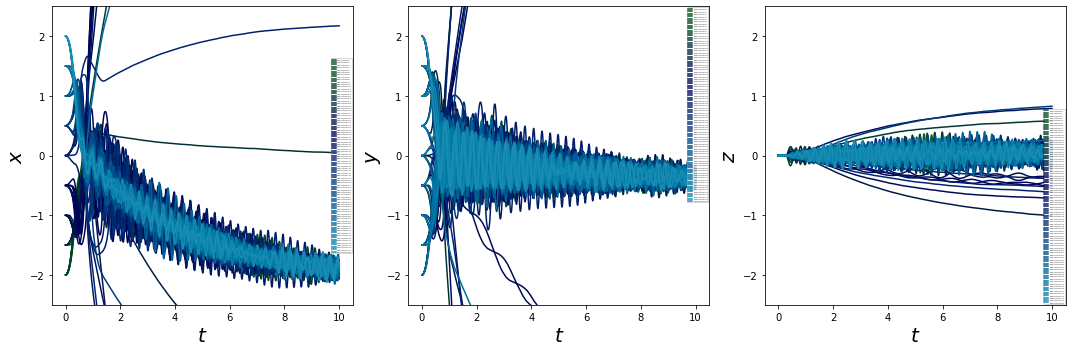

In [29]:
colormap= plt.get_cmap('ocean') 
colors = colormap(np.linspace(0.1,0.7,N_systems))


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx,dimension_key in enumerate(position_dict.keys()):
    for jdx in range(N_systems):
        axes[idx].plot(t_solved,position_dict[dimension_key][:,jdx], color = colors[jdx],
                       label="subsystem %d"%jdx)
        
    axes[idx].set_xlabel(r"$t$", fontsize=20)
    axes[idx].set_ylabel(r"$%s$"%dimension_key, fontsize=20)
    axes[idx].legend(fontsize=2)
    axes[idx].set_ylim([-2.5,2.5])
    
plt.tight_layout()
plt.show()

### B. Electrochemical Dynamics

In [11]:
#extract the electrochemical potentials of the subsystems 
potential_dict = {}
potential_dict["q_1"] = np.zeros((len(t_solved),N_systems))
potential_dict["q_2"]  = np.zeros((len(t_solved),N_systems))
potential_dict["q_3"] = np.zeros((len(t_solved),N_systems))

ec_starting_index = 6*N_systems
for idx in range(N_systems):
    potential_dict["q_1"][:,idx] = solution.y[ec_starting_index+idx*3,:]
    potential_dict["q_2"][:,idx] = solution.y[ec_starting_index+idx*3+1,:]
    potential_dict["q_3"][:,idx] = solution.y[ec_starting_index+idx*3+2,:]

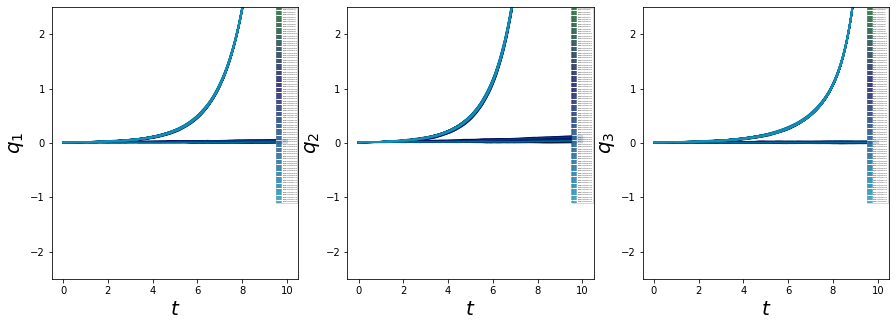

In [30]:
colormap= plt.get_cmap('ocean') 
colors = colormap(np.linspace(0.1,0.7,N_systems))


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx,dimension_key in enumerate(potential_dict.keys()):
    for jdx in range(N_systems):
        axes[idx].plot(t_solved,potential_dict[dimension_key][:,jdx], color = colors[jdx],
                       label="subsystem %d"%jdx)
        
    axes[idx].set_xlabel(r"$t$", fontsize=20)
    axes[idx].set_ylabel(r"$%s$"%dimension_key, fontsize=20)
    axes[idx].legend(fontsize=2)
    axes[idx].set_ylim([-2.5,2.5])

plt.show()

## Positions of the Subsystems in the X-Y Plane

In [13]:
from matplotlib.animation import FuncAnimation
from collections import deque

In [14]:
%matplotlib notebook

In [15]:

def xy_animate(frame_idx):
    line.set_data(position_dict["x"][frame_idx,:], position_dict["y"][frame_idx,:])
    time_text.set_text(time_template % (frame_idx))
    return line, _, time_text
    

<IPython.core.display.Javascript object>


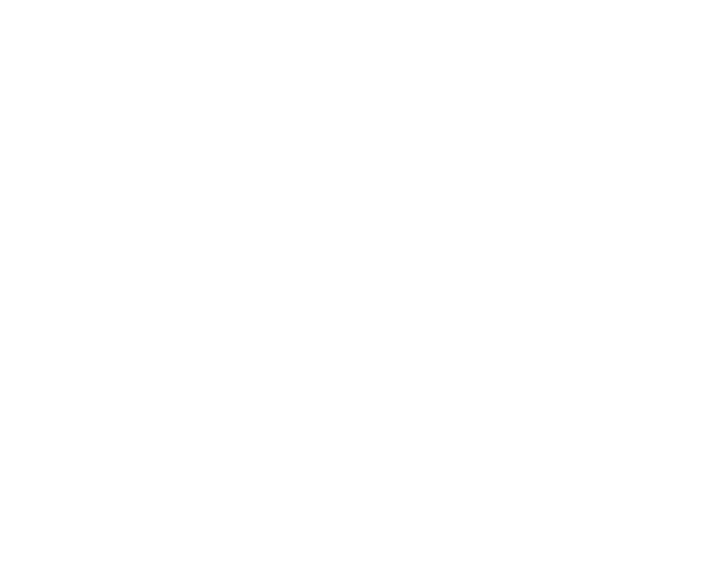

<IPython.core.display.Javascript object>


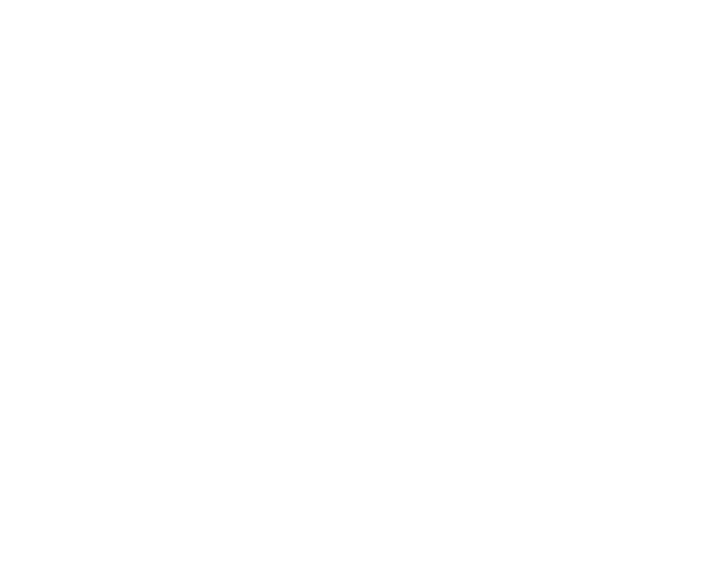

In [16]:
fig = plt.figure(figsize=(5, 4))

#x_mean,y_mean = np.mean(position_dict["x"]),np.mean(position_dict["y"])
#x_std,y_std = np.std(position_dict["x"]), np.std(position_dict["y"])
x_mean,y_mean = 0,0
x_std,y_std  = 4,4

ax = fig.add_subplot(autoscale_on=False, xlim=(x_mean-2.0*x_std, x_mean+2.0*x_std),\
                     ylim=(y_mean-2.0*y_std,y_mean+2.0*y_std))

ax.set_aspect('equal')
ax.grid()


line, = ax.plot([], [], 'o', linestyle="",marker="o")
trace, = ax.plot([], [], '.-', lw=1, ms=2)
time_template = 'time = %d s'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

ani = FuncAnimation(
    fig, xy_animate, frames = len(t_solved), interval= len(t_solved)/100000, blit=True)
plt.show()


## Save Output


In [17]:
output = {"t":t_solved, "potentials":potential_dict, "displacements":position_dict}

FILENAME = "sim_output.p"

try:
    pickle.dump(output, open( FILENAME , "wb" ) )
except:
    print("!!! Failed to save output with filename: %s"%FILENAME)